In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sruthik003","key":"a364112b4126c9809fe860fb90156fe3"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 97% 190M/195M [00:02<00:00, 56.5MB/s]
100% 195M/195M [00:02<00:00, 81.0MB/s]


In [ ]:
!unzip /content/breast-ultrasound-images-dataset.zip

Archive:  /content/breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflat

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models

In [ ]:
# Define the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load the dataset using ImageFolder and split into train and test
dataset = ImageFolder(dataset_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - len(dataset) // 5, len(dataset) // 5])

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define a VGG-based model
class CustomVGG(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        in_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

In [ ]:
# Initialize and train the VGG-based model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomVGG(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 54.8MB/s]


In [ ]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluate the model
model.eval()
true_labels = []
predicted_labels = []

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().tolist())
        predicted_labels.extend(predicted.cpu().tolist())

In [ ]:
# Get class names from the dataset
class_names = dataset.classes

# Calculate accuracy
correct = sum(1 for i in range(len(true_labels)) if true_labels[i] == predicted_labels[i])
accuracy = correct / len(true_labels) * 100

print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 77.46%


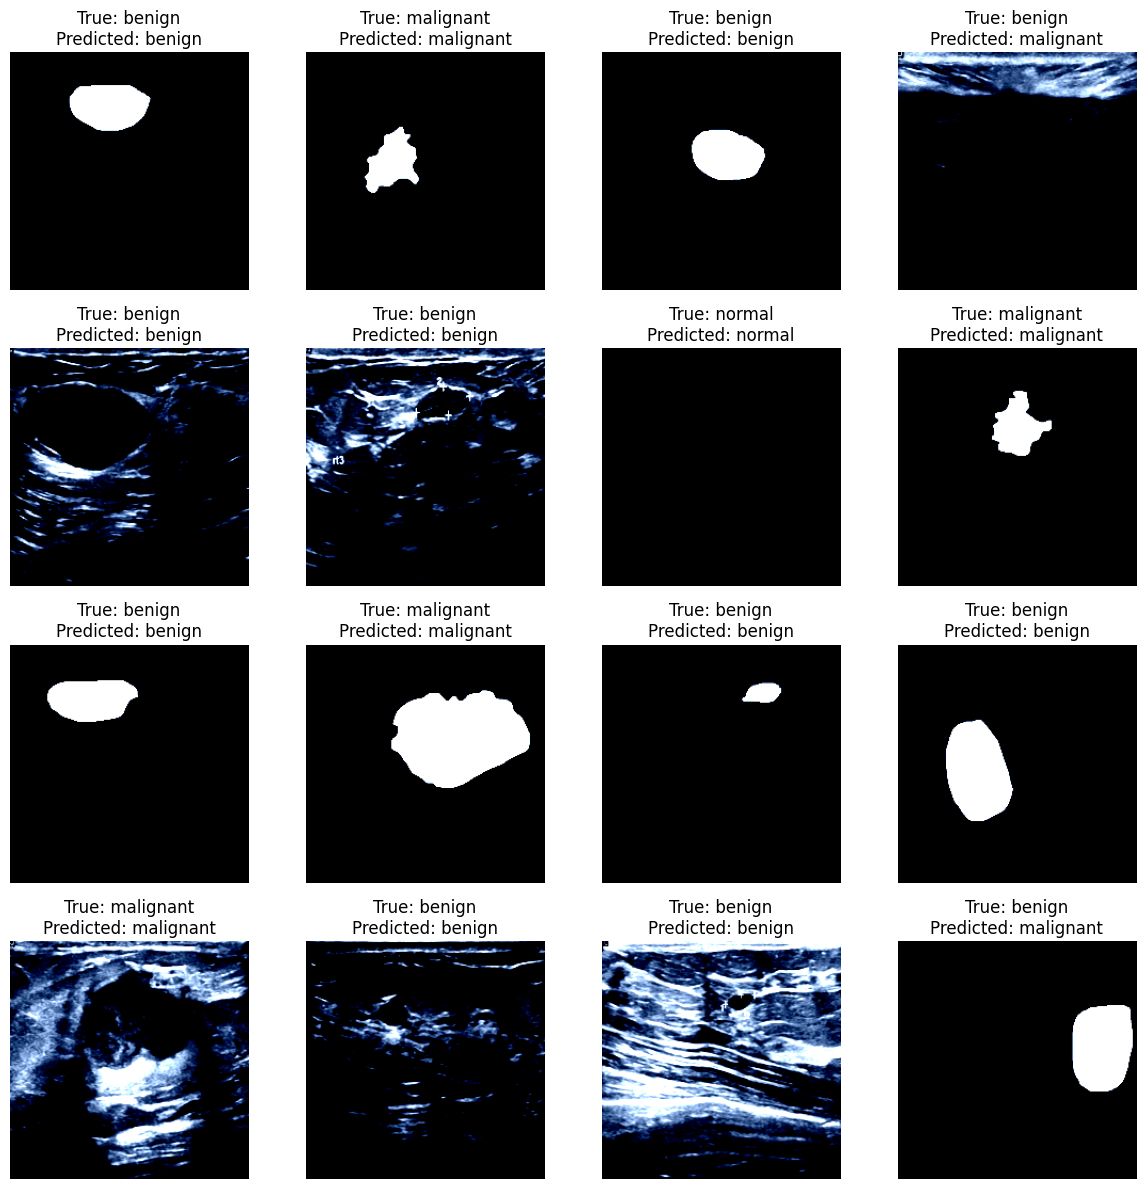

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a grid of images with true and predicted labels
def plot_images_grid(images, true_labels, predicted_labels, class_names, num_rows=4, num_cols=4, figsize=(12, 12)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        ax.imshow(image)
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a grid of random test images
num_samples_to_display = 16
random_indices = random.sample(range(len(test_dataset)), num_samples_to_display)
sample_images = [test_dataset[i][0] for i in random_indices]
sample_labels_true = [true_labels[i] for i in random_indices]
sample_labels_predicted = [predicted_labels[i] for i in random_indices]

# Get class names from the dataset
class_names = dataset.classes

# Plot the grid
plot_images_grid(sample_images, sample_labels_true, sample_labels_predicted, class_names)

In [ ]:
# Define the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset using ImageFolder and split into train and test
dataset = ImageFolder(dataset_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - len(dataset) // 5, len(dataset) // 5])

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define a DenseNet-based model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [ ]:
# Initialize and train the DenseNet-based model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDenseNet(num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 45.1MB/s]


In [ ]:
# Evaluate the model
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().tolist())
        predicted_labels.extend(predicted.cpu().tolist())

# Get class names from the dataset
class_names = dataset.classes

# Calculate accuracy
correct = sum(1 for i in range(len(true_labels)) if true_labels[i] == predicted_labels[i])
accuracy = correct / len(true_labels) * 100

print(f"Accuracy on the test dataset: {accuracy:.2f}%")

Accuracy on the test dataset: 89.84%


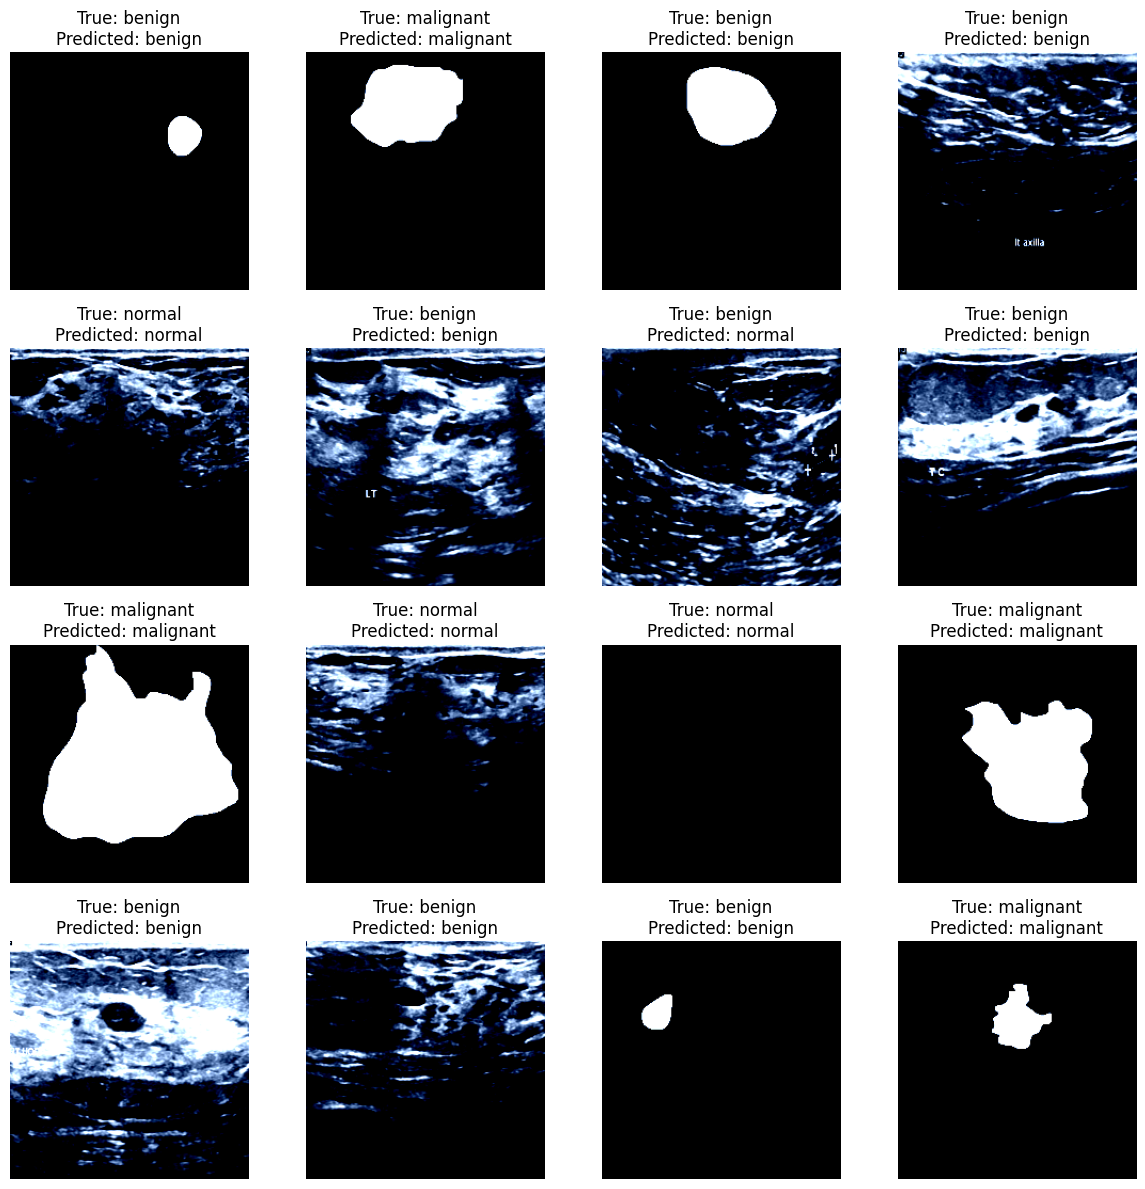

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a grid of images with true and predicted labels
def plot_images_grid(images, true_labels, predicted_labels, class_names, num_rows=4, num_cols=4, figsize=(12, 12)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        ax.imshow(image)
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a grid of random test images
num_samples_to_display = 16
random_indices = random.sample(range(len(test_dataset)), num_samples_to_display)
sample_images = [test_dataset[i][0] for i in random_indices]
sample_labels_true = [true_labels[i] for i in random_indices]
sample_labels_predicted = [predicted_labels[i] for i in random_indices]

# Get class names from the dataset
class_names = dataset.classes

# Plot the grid
plot_images_grid(sample_images, sample_labels_true, sample_labels_predicted, class_names)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random
import numpy as np

# Define the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset using ImageFolder and split into train and test
dataset = ImageFolder(dataset_dir, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - len(dataset) // 5, len(dataset) // 5])

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define a VGG-based model
class CustomVGG(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        in_features = self.vgg.classifier[0].in_features
        self.vgg.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Define a DenseNet-based model
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

# Initialize and train both models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = CustomVGG(num_classes=len(dataset.classes)).to(device)
densenet_model = CustomDenseNet(num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.0001)
optimizer_densenet = optim.Adam(densenet_model.parameters(), lr=0.0001)

# Training Loop for VGG model
num_epochs = 30
for epoch in range(num_epochs):
    vgg_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_vgg.zero_grad()
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()

# Training Loop for DenseNet model
for epoch in range(num_epochs):
    densenet_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()

# Evaluate both models
vgg_model.eval()
densenet_model.eval()
true_labels = []
predicted_labels_vgg = []
predicted_labels_densenet = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_vgg = vgg_model(inputs)
        outputs_densenet = densenet_model(inputs)

        _, predicted_vgg = torch.max(outputs_vgg, 1)
        _, predicted_densenet = torch.max(outputs_densenet, 1)

        true_labels.extend(labels.cpu().tolist())
        predicted_labels_vgg.extend(predicted_vgg.cpu().tolist())
        predicted_labels_densenet.extend(predicted_densenet.cpu().tolist())

# Combine predictions from both models (e.g., by taking the mode)
combined_predictions = [np.argmax(np.bincount([predicted_labels_vgg[i], predicted_labels_densenet[i]])) for i in range(len(true_labels))]

# Get class names from the dataset
class_names = dataset.classes

# Calculate accuracy for combined predictions
correct_combined = sum(1 for i in range(len(true_labels)) if true_labels[i] == combined_predictions[i])
accuracy_combined = correct_combined / len(true_labels) * 100

print(f"Accuracy on the test dataset (Combined): {accuracy_combined:.2f}%")


Accuracy on the test dataset (Combined): 94.60%


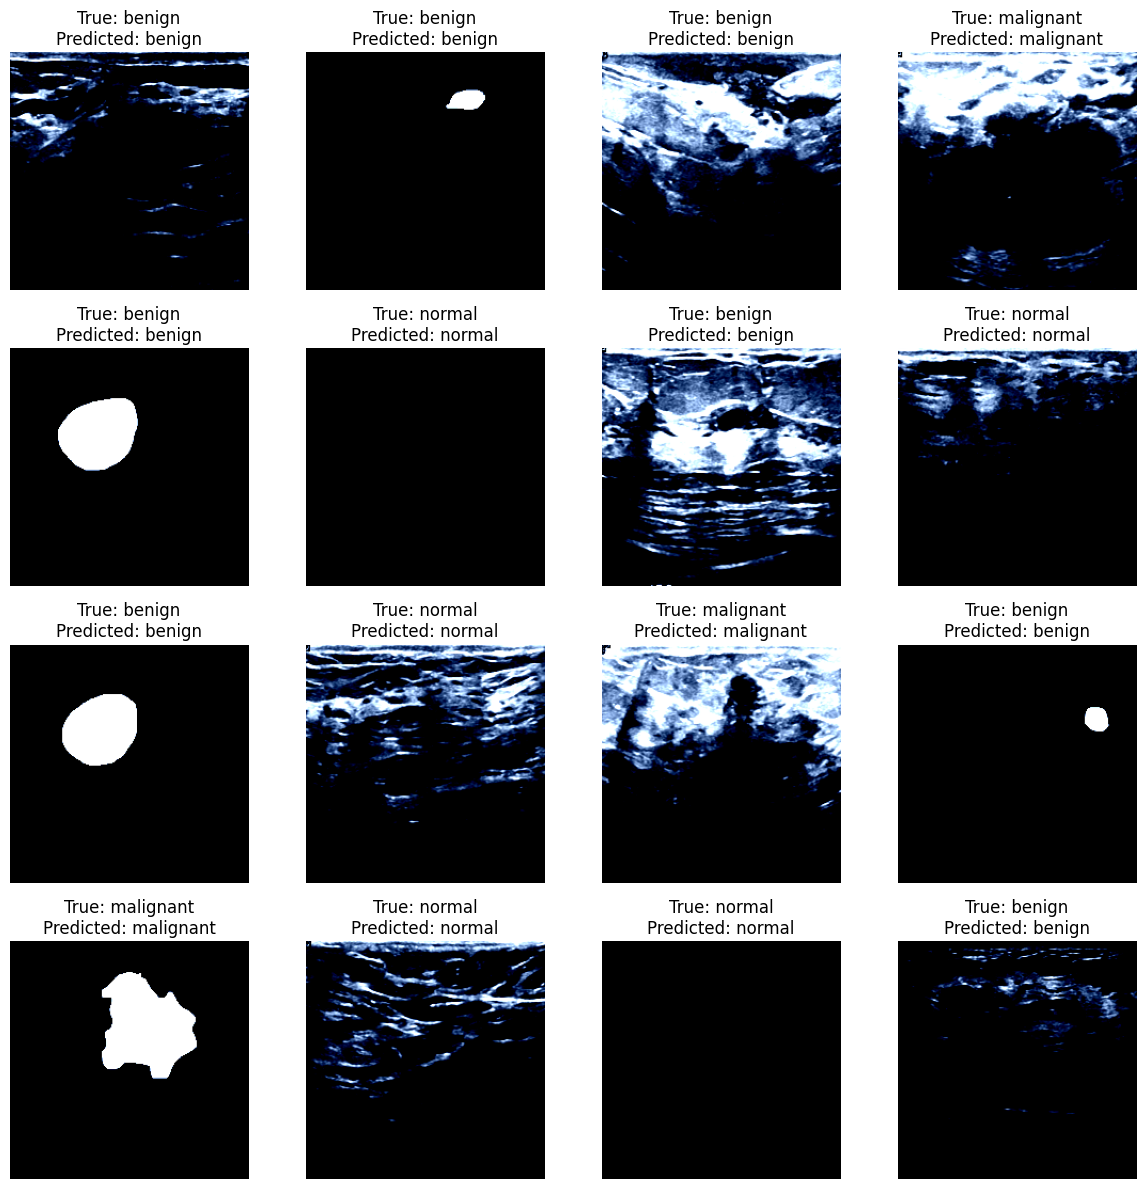

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a grid of images with true and predicted labels
def plot_images_grid(images, true_labels, predicted_labels, class_names, num_rows=4, num_cols=4, figsize=(12, 12)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        ax.imshow(image)
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a grid of random test images with true and predicted labels
num_samples_to_display = 16
random_indices = random.sample(range(len(test_dataset)), num_samples_to_display)
sample_images = [test_dataset[i][0] for i in random_indices]
sample_labels_true = [true_labels[i] for i in random_indices]
sample_labels_predicted = [combined_predictions[i] for i in random_indices]

# Get class names from the dataset
class_names = dataset.classes

# Plot the grid
plot_images_grid(sample_images, sample_labels_true, sample_labels_predicted, class_names)

In [ ]:
import pickle

# Specify the path to the saved ensemble model file
ensemble_model_path = 'ensemble_model.pkl'  # Replace with the desired file path

# Serialize the ensemble model and related data
ensemble_data = {
    'vgg_model_state_dict': vgg_model.state_dict(),
    'densenet_model_state_dict': densenet_model.state_dict(),
    'combined_predictions': combined_predictions,
}

# Save the serialized data to a file using pickle
with open(ensemble_model_path, 'wb') as file:
    pickle.dump(ensemble_data, file)

print(f"Ensemble model saved to {ensemble_model_path}")


Ensemble model saved to ensemble_model.pkl


In [ ]:
import os

# Specify the path to the saved ensemble model file
ensemble_model_path = 'ensemble_model.pkl'  # Replace with the actual file path

# Get the file size in bytes
model_size_bytes = os.path.getsize(ensemble_model_path)

# Convert bytes to megabytes (MB)
model_size_mb = model_size_bytes / (1024 ** 2)  # 1 MB = 1024^2 bytes

print(f"Size of the saved ensemble model: {model_size_mb:.2f} MB")


Size of the saved ensemble model: 134.28 MB
